In [4]:
import sys
sys.path.append("../src")

import numpy as np
import matplotlib.pyplot  as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from src.common_utils.basic_operations import load_img_label_from_path,crop_or_pad,rescale_intensity
from src.models.model_util import makeVariable
from src.models.advanced_triplet_recon_segmentation_model import AdvancedTripletReconSegmentationModel
from src.models.model_util import _disable_tracking_bn_stats
from src.models.custom_loss import cross_entropy_2D
torch.cuda.empty_cache()
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"
%matplotlib inline

torch.cuda.empty_cache()




ModuleNotFoundError: No module named 'src'

In [2]:
def load_and_preprocess_image(image_path, label_path,image_size = (192,192)):
    image, label, sitkimg,sitklabel = load_img_label_from_path(image_path,label_path)
    image,label, _,_,_,_ = crop_or_pad(image=image, label=label,crop_size=image_size)
    print(f'load image: {image.shape}, label: {label.shape}')
    return image,label,sitkimg,sitklabel

# 1. Load data


In [97]:
num_classes = 4
# ## here we load the model trained w/ standard training
#+diffuse_style_mix_style_seg_loss_only_lr_0_5+art_style
checkpoint_dir = '../saved/train_ACDC_standard_n_cls_4/ACDC/600_epoch/standard_training/0/model/best/checkpoints'
image_size = (192,192)
network_type = 'FCN_16_standard'
np.random.seed(202202022)
# pids= ['049','009']
pids =['006','003','004','005','001','061', '049','009']
slice_id = 0
img_list=[]
label_list=[]
for pid in pids:
    image_path = f'/vol/biomedic3/cc215/data/ACDC/bias_corrected_and_normalized/patient_wise/{pid}/ED_img.nrrd'
    label_path = f'/vol/biomedic3/cc215/data/ACDC/bias_corrected_and_normalized/patient_wise/{pid}/ED_seg.nrrd'
    image,label,sitkimg,sitklabel = load_and_preprocess_image(image_path,label_path,image_size)
    slice_id = np.random.randint(0,image.shape[0])
    img_list.append(image[[slice_id]])
    label_list.append(label[[slice_id]])
image= np.concatenate(img_list,0)
label = np.concatenate(label_list,0)



load image: (11, 192, 192), label: (11, 192, 192)
load image: (10, 192, 192), label: (10, 192, 192)
load image: (10, 192, 192), label: (10, 192, 192)
load image: (10, 192, 192), label: (10, 192, 192)
load image: (10, 192, 192), label: (10, 192, 192)
load image: (9, 192, 192), label: (9, 192, 192)
load image: (7, 192, 192), label: (7, 192, 192)
load image: (10, 192, 192), label: (10, 192, 192)


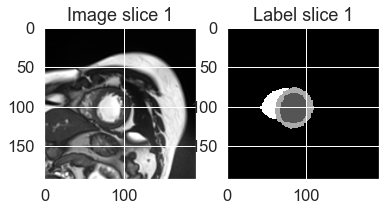

In [48]:
slice_id=1
plt.subplot(121)
plt.title(f'Image slice {slice_id}')
plt.imshow(image[slice_id],cmap='gray')
plt.subplot(122)
plt.title(f'Label slice {slice_id}')
plt.imshow(label[slice_id],cmap='gray',interpolation='nearest')
plt.show()

# 2. Load saved models (dual-branch network)

In [1]:
network_type = "FCN_16_standard_no_STN"
checkpoint_dir ="/vol/biomedic3/cc215/Project/MaxStyle/saved/train_ACDC_10_n_cls_4/config/ACDC/1500_epoch/MICCAI2022_MaxStyle/0/model/best/checkpoints"

segmentation_model = AdvancedTripletReconSegmentationModel(network_type = network_type,
                                                          checkpoint_dir=checkpoint_dir,
                                                          num_classes=num_classes,use_gpu=True,debug=False)


segmentation_model.eval()

NameError: name 'AdvancedTripletReconSegmentationModel' is not defined

# 3. Extract latent image content code z_i and shape code z_s

In [98]:
torch.cuda.empty_cache()
imageV = makeVariable(torch.from_numpy(image[:,np.newaxis,:,:]),type='float',requires_grad=False,use_gpu=True)
labelV = makeVariable(torch.from_numpy(label),type='long',requires_grad=False,use_gpu=True)
imageV = rescale_intensity(imageV)
segmentation_model.train()
with _disable_tracking_bn_stats(segmentation_model.model['image_encoder']):
    z_i,z_s = segmentation_model.model['image_encoder'](imageV)


z_i_before_relu = segmentation_model.model['image_encoder'].general_encoder.before_act
z_i_after_relu = segmentation_model.model['image_encoder'].general_encoder.after_act


# 3. Insert StyleMix Layers to Decoder 

adv art style augmentation tensor([0.8403, 0.8596, 0.2719, 0.5599, 0.6106, 0.5375, 0.0270, 0.5778],
       device='cuda:0', requires_grad=True) 
before: tensor(0.2717, device='cuda:0', grad_fn=<DivBackward0>)
after: tensor(0.3283, device='cuda:0', grad_fn=<DivBackward0>)
adv art style augmentation tensor([ 0.9403,  0.9596,  0.1719,  0.4599,  0.7106,  0.4375, -0.0730,  0.6778],
       device='cuda:0', grad_fn=<AddBackward0>) 
after: tensor(0.3622, device='cuda:0', grad_fn=<DivBackward0>)
adv art style augmentation tensor([ 1.0403,  1.0596,  0.0719,  0.5599,  0.8106,  0.3375, -0.0730,  0.7778],
       device='cuda:0', grad_fn=<AddBackward0>) 
after: tensor(0.3688, device='cuda:0', grad_fn=<DivBackward0>)
adv art style augmentation tensor([ 1.0403,  1.0596, -0.0281,  0.4599,  0.9106,  0.2375, -0.0730,  0.8778],
       device='cuda:0', grad_fn=<AddBackward0>) 
after: tensor(0.3797, device='cuda:0', grad_fn=<DivBackward0>)
adv art style augmentation tensor([ 1.0403,  1.0596, -0.0281,  0.559

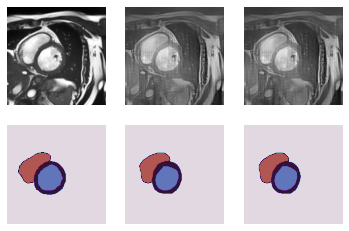

In [99]:
from medseg.advanced.art_style_augmentation import AdvArtStyleAugmentor
import seaborn as sns
import torch
torch.cuda.empty_cache()
segmentation_model.eval()

torch.manual_seed(12367)
lr=0.1
n_iter = 5
augmentor = AdvArtStyleAugmentor(imageV.size(0),rand_w=True)
optimizer = torch.optim.Adam(augmentor.parameters(),lr=1e-1)
optimizer.zero_grad()
rand_styliezed_image = augmentor(imageV, lazy_load=True)
rand_styliezed_image = torch.clamp(rand_styliezed_image,0,1)
print (augmentor)
recon,p,p_recon  =segmentation_model.run(rand_styliezed_image,True)

art_z_i  =segmentation_model.z_i
equal_prob = torch.ones_like(p)/p.size(1)


L_seg = cross_entropy_2D(p, labelV.detach().clone())
ce = cross_entropy_2D(p, labelV.detach().clone())
print ('before:',ce)
predict_label  = p.max(1)[1].cpu().data.numpy()

if n_iter>0:
    for i in range (1,n_iter+1):
        segmentation_model.zero_grad()
        # optimizer.zero_grad() 
        # L_seg.backward()
        # optimizer.step()
        augmentor.w_weights= augmentor.w_weights+0.1*torch.autograd.grad(L_seg,[augmentor.w_weights])[0].sign()
        adv_styliezed_image = augmentor(imageV, lazy_load=True)
        recon,p_adv,p_recon  =segmentation_model.run(adv_styliezed_image,True)
        # L_seg = -cross_entropy_2D(p_adv, labelV.detach().clone())
        # equal_prob = torch.ones_like(p_adv)/p.size(1)
        L_seg =cross_entropy_2D(p_adv, labelV.detach().clone())
        ce = cross_entropy_2D(p_adv, labelV.detach().clone())
        adv_label  = p_adv.max(1)[1].cpu().data.numpy()
        print ('after:',ce)
        print (augmentor)
    adv_styliezed_image = augmentor(imageV, lazy_load=True)

else:
    adv_styliezed_image = rand_styliezed_image

slice_id=1
label_cmap = 'twilight'
plt.subplot(231)
plt.imshow(image[slice_id],cmap='gray')
plt.grid('off')
plt.axis('off')

plt.subplot(232)
plt.imshow(rand_styliezed_image.data.cpu().numpy()[slice_id,0],cmap='gray')
plt.grid('off')
plt.axis('off')

plt.subplot(233)
plt.grid('off')
plt.axis('off')

plt.imshow(adv_styliezed_image.data.cpu().numpy()[slice_id,0],cmap='gray')
plt.subplot(234)
plt.imshow(label[slice_id], cmap=label_cmap,vmin=0,vmax=num_classes)
plt.grid('off')
plt.axis('off')

plt.subplot(235)
plt.grid('off')
plt.axis('off')

plt.imshow(predict_label[slice_id], cmap=label_cmap,vmin=0,vmax=num_classes)
plt.subplot(236)
plt.imshow(adv_label[slice_id], cmap=label_cmap,vmin=0,vmax=num_classes)
plt.grid('off')
plt.axis('off')

sns.axisgrid=False

In [52]:
from styleaug import StyleAugmentor
from medseg.models.model_util import set_grad
class AdvArtStyleAugmentor(nn.Module):
    """adv art style augmentation with adv training on the interpolation weights.
    """

    def __init__(self, batch_size, use_gpu=True, rand_w=False):
        """
        Args:
          batch_size (int): number of images in each batch
          eps (float): scaling parameter to avoid numerical issues.
        """
        super().__init__()
        self.batch_size = batch_size
        self.eps = 1e-8

        self.device = torch.device('cuda') if use_gpu else torch.device('cpu')
        # if rand_w:
        #     self.w_weights = torch.rand(batch_size, device=self.device)
        # else:
        #     self.w_weights = torch.ones(batch_size, device=self.device)*0.5
        self.w_weights = nn.Parameter(torch.empty(batch_size,device=self.device,dtype=torch.float))
        if not rand_w:
            torch.nn.init.constant_(self.w_weights,0.5)
        else:
            torch.nn.init.uniform_(self.w_weights)
        self.w_weights.requires_grad=True
        self.style_augmentor = StyleAugmentor()
        self.style_augmentor.eval()
        set_grad(self.style_augmentor.ghiasi,False)
        set_grad(self.style_augmentor.stylePredictor,False)

        self.style_augmentor.ghiasi.eval()
        self.style_augmentor.stylePredictor.eval()
        self.embedding = None

    def __repr__(self):
        return f'adv art style augmentation {self.w_weights} '

    def forward(self, im_tensor, lazy_load=False):
        w_weights = torch.clamp(self.w_weights, 0, 1)
        n, c, h, w = im_tensor.size()
        if c == 1:
            im_tensor_rgb = im_tensor.expand(n, 3, h, w)
        elif c == 3:
            im_tensor_rgb = im_tensor
        else:
            print(f'check input dim, either gray scale images (c=1) or rgb images (c=3), got c={c}')
            raise ValueError

        base = self.style_augmentor.stylePredictor(im_tensor_rgb)

        if self.embedding is None or not lazy_load:
            print ('sample new style')
            # sample a random embedding
            self.embedding = self.style_augmentor.sample_embedding(n) ## n* 100
            print (self.embedding.size())
        # interpolate style embeddings:
        w_weights =w_weights[:,None]
        w_weights = w_weights.expand(n, self.embedding.size(1))
        embedding = (w_weights )* self.embedding + (1-w_weights) * base
        stylized_image = self.style_augmentor.ghiasi(im_tensor_rgb, embedding)
        # convert back to gray
        if c == 1:
            stylized_image = torch.mean(stylized_image, dim=1, keepdim=True)

        return stylized_image

In [53]:
from medseg.models.model_util import _disable_tracking_bn_stats
from medseg.advanced.mixup import ManifoldMixup

def mixup_inference(x,  decoder_function,label_map=None,num_classes=None,layers_indexes=[],lmda=None,use_gpu=True):
    ## apply mixup in the decoder path 
    if len(layers_indexes)==0:
        with _disable_tracking_bn_stats(decoder_function):
            y= decoder_function(x)
        return y,label_map,torch.arange(x.size(0)).to(x.device)
    elif len(layers_indexes)==1:
        ## only support one layer to mixup
        print(layers_indexes)
        mixup_util = ManifoldMixup(alpha=2.0,use_gpu=use_gpu)
        if lmda is not None:
            ## if lam has been provided, then use the provided one
            mixup_util.lam =lmda
        with _disable_tracking_bn_stats(decoder_function):
            if 0 in layers_indexes:
                x,label_map = mixup_util.get_mixup_data(x,label_map,num_classes=num_classes)
            x2 = decoder_function.up1(x)
            if 1 in layers_indexes:
                x2,label_map = mixup_util.get_mixup_data(x2,label_map,num_classes=num_classes)
            x3 = decoder_function.up2(x2)
            if 2 in layers_indexes:
                x3,label_map =mixup_util.get_mixup_data(x3,label_map,num_classes=num_classes)
            x4 = decoder_function.up3(x3)

            if 3 in layers_indexes:
                x4,label_map =mixup_util.get_mixup_data(x4,label_map,num_classes=num_classes)
            x5 = decoder_function.up4(x4)
            if 4 in layers_indexes:
                x5,label_map =mixup_util.get_mixup_data(x5,label_map,num_classes=num_classes)
            x5 = decoder_function.final_conv(x5)
            if decoder_function.last_act is not None:
                x5 = decoder_function.last_act(x5)
        return x5,label_map,mixup_util.perm_index
    else:
        raise ValueError("only features of one layer can be mixed")

In [54]:
## batch_wise_similarity
def compute_batchwise_sim(a,b):
    a = a.view(a.size(0),-1)
    b = b.view(b.size(0),-1)
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)(a,b)
    return cos
from medseg.common_utils.measure import dc
def compute_batchwise_dice(a,b, n_classes=2):
    '''
    a: 3D numpy array pred
    b: 3D numpy array gt
    '''
    assert n_classes>=2
    batch_dice= []
    for j in range(a.shape[0]):
        dice_per_classes = []
        for c in range(1,n_classes):
            gt_c_i = np.copy(b)
            gt_c_i[gt_c_i != c] = 0
            gt_c_i[gt_c_i == c] = 1

            pred_c_i = np.copy(a)
            pred_c_i[pred_c_i != c] = 0
            pred_c_i[pred_c_i == c] = 1

            dice = dc(result=pred_c_i, reference=gt_c_i)
            dice_per_classes.append(dice)
        avg_dice = sum(dice_per_classes)/(1.0*len(dice_per_classes))
        batch_dice.append(avg_dice)
    return batch_dice

import torch

def cov(m, rowvar=False):
    '''Estimate a covariance matrix given data.

    Covariance indicates the level to which two variables vary together.
    If we examine N-dimensional samples, `X = [x_1, x_2, ... x_N]^T`,
    then the covariance matrix element `C_{ij}` is the covariance of
    `x_i` and `x_j`. The element `C_{ii}` is the variance of `x_i`.

    Args:
        m: A 1-D or 2-D array containing multiple variables and observations.
            Each row of `m` represents a variable, and each column a single
            observation of all those variables.
        rowvar: If `rowvar` is True, then each row represents a
            variable, with observations in the columns. Otherwise, the
            relationship is transposed: each column represents a variable,
            while the rows contain observations.

    Returns:
        The covariance matrix of the variables.
    '''
    if m.dim() > 2:
        raise ValueError('m has more than 2 dimensions')
    if m.dim() < 2:
        m = m.view(1, -1)
    if not rowvar and m.size(0) != 1:
        m = m.t()
    m = m-torch.mean(m, dim=1, keepdim=True)
    mt = m.t()  # if complex: mt = m.t().conj()
    return  m.matmul(mt).squeeze()

In [55]:
# visualization
def vis_result_dict(ref_image,result_dict, ref_gt =None,figsize=None):
    num_items = len(result_dict.keys())
    list_results = list(result_dict.values())
    num_slices = list_results[0][0].size(0)
    n_rows = 2

    if figsize is  None:
        figsize=(num_items+1,n_rows*num_slices)
    fig,axes = plt.subplots(n_rows*num_slices,num_items+1,figsize=figsize,sharex=True)
    for slice_id in range(num_slices):
        axes[n_rows*slice_id,0].imshow(ref_image[slice_id],cmap='gray',interpolation =None,vmin=0,vmax=1)
        if ref_gt is not None: axes[n_rows*slice_id+1,0].imshow(ref_gt[slice_id],vmin=0,vmax=3,interpolation ='nearest',cmap='jet')

        axes[n_rows*slice_id,0].set_title ('Input')
        axes[n_rows*slice_id+1,0].set_title ('Seg')

        axes[n_rows*slice_id,0].axis('off')
        axes[n_rows*slice_id+1,0].axis('off')
 
        # axes[n_rows*slice_id+2,0].imshow(np.ones_like(ref_image[slice_id]),cmap='gray',interpolation =None,vmin=0,vmax=1)
        # axes[n_rows*slice_id+2,0].axis('off')
        # axes[n_rows*slice_id+2,0].set_title ('Diff')
        i = 0 
        for method, val_list in result_dict.items():
            axes[n_rows*slice_id,1+i].set_title (str(method))
            axes[n_rows*slice_id,1+i].imshow(val_list[0].detach().cpu().numpy()[slice_id,0],cmap='gray',interpolation =None,vmin=0,vmax=1)
            axes[1+n_rows*slice_id,1+i].imshow(val_list[3][slice_id],vmin=0,vmax=3,interpolation ='nearest',cmap='jet')

            axes[n_rows*slice_id,1+i].axis('off')
            axes[1+n_rows*slice_id,1+i].axis('off')

            # axes[2+n_rows*slice_id,1+i].axis('off')
            # axes[2+n_rows*slice_id,1+i].imshow(val_list[0].detach().cpu().numpy()[slice_id,0]-image[slice_id],vmin=-1,vmax=1,interpolation =None,cmap='RdBu')

            img_code_preservation = val_list[1][slice_id]
            shape_code_preservation = val_list[2][slice_id]
            try:
                img_code_preservation = img_code_preservation.cpu().numpy()
            except: 
                pass
            try:
                shape_code_preservation = shape_code_preservation.cpu().numpy()
            except: 
                pass
            img_code_preservation= np.round(img_code_preservation,2)
            shape_code_preservation= np.round(shape_code_preservation,2)
            # axes[1+n_rows*slice_id,1+i].set_title (str(img_code_preservation)+'/'+str(shape_code_preservation))
            i+=1
        # axes[1+2*slice_id,1+i].set_title (str(method))
    plt.tight_layout(h_pad=0.1,w_pad=0)

# 5. Visualization: Generated challenging examples by different masking schemes

In [60]:
# import seaborn as sns
# ## Note: here, we use the target style statistics each time for ease of comparison
# layers_settings =[[2,3,4]] #,[2],[3],[4],[2,3],[2,4],[3,4],[2,3,4],[1,2,3,4]]
#                 #     [],[0],[1],[2],[3],[4],[3,4],[2,3,4],[1,2,3,4],
#                 # [0,1],[1,2],[2,3], [3,4],[0,2],[1,3],[2,4],[0,3],[1,4]]
#                 #    
#                 # [0,1,2,3,4],[0,1,2],[1,2,3],[2,3,4]]
# sns.set()
# lmda=None
# mix='random'
# extrapolate=True
# p=1
# results = {}
# torch.manual_seed(122)
# segmentation_model.eval()
# for j,layer_index_list in enumerate(layers_settings):
#     # corrupted_img = segmentation_model.generate_style_augmented_images(image_code=z_i, decoder_layers_indexes=layer_index_list, lmda=lmda, mix=mix, 
#     #                             if_extraplolate=extrapolate, p=p,
#     #                                 random_layers=False, mix_before_act=False)

#     corrupted_img = generate_style_extrapolated_images(z_i,segmentation_model,decoder_layers_indexes=layer_index_list,p=p, 
#                                                     n_iter=1,lr=0.1,seg_weight=1,ngf_weight=0,ent_weight=0,content_weight=0,mix_style=True,no_noise=False,
#                                                     reference_image=imageV, reference_segmentation=labelV,noise_learnable=True,mix_learnable=False,adaptive_weight=False)


      
#     corrupted_img = rescale_intensity(corrupted_img,0,1)
#     with torch.no_grad():
#         zi_new,zs_new = segmentation_model.encode_image(corrupted_img.detach().clone(),disable_track_bn_stats=True)
#         code_preserve_ratio = compute_batchwise_sim(zi_new,z_i)
#         shape_code_preserve_ratio = compute_batchwise_sim(zs_new,z_s)
#         init_p = segmentation_model.decode_segmentation(zs_new)

#     predicted_maps = init_p.max(1)[1].cpu().numpy()
#     dice_scores = compute_batchwise_dice(predicted_maps,label)
#     losses = []
#     for sid in range(imageV.size(0)):
#         l_seg_1, l_rec, _, l_shape_1 = segmentation_model.standard_training(imageV[[sid]],labelV[[sid]], corrupted_img[[sid]], compute_gt_recon=False, update_latent=False, if_latent_code_consistency=False,
#                                                                                          disable_track_bn_stats=True, domain_id=0)
#         style_extrapolation_decoder_loss = l_seg_1
#         losses.append(style_extrapolation_decoder_loss.item())
    
#     results[str(layer_index_list)] = [corrupted_img,losses,dice_scores,predicted_maps]

# vis_result_dict(ref_image=image,ref_gt = label,result_dict=results)




In [12]:
def normalized_cross_correlation(x, y, return_map, reduction='mean', eps=1e-8):
    """ N-dimensional normalized cross correlation (NCC)
    Args:
        x (~torch.Tensor): Input tensor.
        y (~torch.Tensor): Input tensor.
        return_map (bool): If True, also return the correlation map.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``'mean'`` | ``'sum'``. Defaults to ``'sum'``.
        eps (float, optional): Epsilon value for numerical stability. Defaults to 1e-8.
    Returns:
        ~torch.Tensor: Output scalar
        ~torch.Tensor: Output tensor
    """

    shape = x.shape
    b = shape[0]

    # reshape
    x = x.view(b, -1)
    y = y.view(b, -1)

    # mean
    x_mean = torch.mean(x, dim=1, keepdim=True)
    y_mean = torch.mean(y, dim=1, keepdim=True)

    # deviation
    x = x - x_mean
    y = y - y_mean

    dev_xy = torch.mul(x,y)
    dev_xx = torch.mul(x,x)
    dev_yy = torch.mul(y,y)

    dev_xx_sum = torch.sum(dev_xx, dim=1, keepdim=True)
    dev_yy_sum = torch.sum(dev_yy, dim=1, keepdim=True)

    ncc = torch.div(dev_xy + eps / dev_xy.shape[1],
                    torch.sqrt( torch.mul(dev_xx_sum, dev_yy_sum)) + eps)
    ncc_map = ncc.view(b, *shape[1:])

    # reduce
    if reduction == 'mean':
        ncc = torch.mean(torch.sum(ncc, dim=1))
    elif reduction == 'sum':
        ncc = torch.sum(ncc)
    else:
        raise KeyError('unsupported reduction type: %s' % reduction)

    if not return_map:
        return ncc

    return ncc, ncc_map


In [13]:
import torch
import medseg.common_utils.morphology as morphologylib
import importlib
import math
import medseg.models.custom_loss as loss_lib
import sys
# from medseg.common_utils.morphology import Dilation2d

sys.path.append('/vol/biomedic3/cc215/Project/pytorch_similarity')
from torch_similarity.modules import GradientCorrelation2d
importlib.reload(morphologylib)
importlib.reload(loss_lib)
class NGF(torch.nn.Module):
    def __init__(self,epsilon=None,size_average=True, sigma=3,
                 reduction='mean',use_gpu=True):
        super(NGF, self).__init__()

        self._name = "ngf"
        self.size_average = size_average
        self.reduction = reduction
        self._epsilon = epsilon
        self.use_gpu=use_gpu
        self.sigma=sigma
    def forward(self,input_image, reference_image, mask=None,dilate_mask=0):
        reference_image=reference_image.detach()        
        fixed_gradient= self.normalized_gradient(reference_image)
        moving_gradient = self.normalized_gradient(input_image)
   
   
        n,c,h,w = input_image.size()
        if mask is None:
            mask = torch.ones(n,h,w).to(input_image.device)
        else:
            mask[mask>0]=1
            if dilate_mask>0:
                mask = mask.float()
                mask= mask[:,None]
                mask.requires_grad=False 
                mask = morphologylib.Dilation2d(1,1,kernel_size=5,soft_max=False,requires_grad=False,use_gpu=self.use_gpu)(mask)
                mask=mask[:,0]
        
            
        self.fixed_gradient=fixed_gradient*torch.cat([mask[:,None],mask[:,None]],dim=1)
        self.moving_gradient=moving_gradient*torch.cat([mask[:,None],mask[:,None]],dim=1)
        value_map =  fixed_gradient*moving_gradient
        value =torch.mean(value_map,dim=1)*mask
        ncc_x,self.ncc_map_x = normalized_cross_correlation(self.fixed_gradient[:,0],self.moving_gradient[:,0],True,'sum')
        ncc_x,self.ncc_map_y = normalized_cross_correlation(self.fixed_gradient[:,1],self.moving_gradient[:,1],True,'sum')

        self.ncc_map = torch.sqrt(self.ncc_map_x**2+self.ncc_map_y**2)
        # self.ncc_map = self.ncc_map
        # print (torch.max(self.ncc_map,dim=0,keepdim=True).value)
        # f_g = self.fixed_gradient.view(n,-1)
        # m_g = self.moving_gradient.view(n,-1)
        # cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        # self.ncc_map = cos
        # print (self.ncc_map.size())
        if self.size_average:
            if self.reduction =='mean':
                value = torch.mean(value)
            elif self.reduction =='sum':
                value = torch.sum(value)
            else: raise ValueError
        value=-value
        # print ('loss:',value.item())
        return value

    def get_gaussian_kernel(self, kernel_size=5, sigma=8, channels=3):
        # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
        # Use n_sd sigmas
        if kernel_size < 2 * int(3.5 * sigma) + 1:
            # odd size so padding results in correct output size
            kernel_size = 2 * int(3.5 * sigma) + 1

        x_coord = torch.arange(kernel_size)
        x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

        mean = (kernel_size - 1) / 2.
        variance = sigma ** 2.

        # Calculate the 2-dimensional gaussian kernel which is
        # the product of two gaussian distributions for two different
        # variables (in this case called x and y)
        gaussian_kernel = (1. / (2. * math.pi * variance)) * \
            torch.exp(
            -torch.sum((xy_grid - mean) ** 2., dim=-1) /
            (2 * variance)
        )

        # Make sure sum of values in gaussian kernel equals 1.
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

        # Reshape to 2d depthwise convolutional weight
        gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)
        pad_size = kernel_size // 2
        gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                    kernel_size=kernel_size, groups=channels, dilation=1, stride=1, bias=False,
                                    padding=pad_size)

        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.data = gaussian_kernel
        gaussian_filter.weight.requires_grad = False
        if self.use_gpu:
            gaussian_filter = gaussian_filter.cuda()
        return gaussian_filter
    
    def normalized_gradient(self,image):
        ## Approximate the gradient by short differences
        n,c,h,w = image.size()
        image = self.get_gaussian_kernel(kernel_size=7,sigma=self.sigma,channels=image.size(1))(image).clone()
        # dx = (image[..., 1:, 1:] - image[..., :-1, 1:]) 
        # dy = (image[..., 1:, 1:] - image[..., 1:, :-1])

        ## use sobel filter to get dx and dy
        x_filter = np.array([[1, 0, -1],
                         [2, 0, -2],
                         [1, 0, -1]]).reshape(1, 1, 3, 3)

        x_filter = np.repeat(x_filter, axis=1, repeats=image.size(1))
        x_filter = np.repeat(x_filter, axis=0, repeats=image.size(1))
        y_filter = np.array([[1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]]).reshape(1, 1, 3, 3)

     
        y_filter = np.array([[1, 2, 1],
                         [0, 0, 0],
                         [-1, -2, -1]]).reshape(1, 1, 3, 3)
        y_filter = np.repeat(y_filter, axis=1, repeats=image.size(1))
        y_filter = np.repeat(y_filter, axis=0, repeats=image.size(1))

        conv_x = nn.Conv2d(in_channels=image.size(1), out_channels=image.size(1), kernel_size=3, stride=1, padding=1,
                        dilation=1, bias=False)
        conv_x.weight = nn.Parameter(torch.from_numpy(x_filter).float())

        conv_y = nn.Conv2d(in_channels=image.size(1), out_channels=image.size(1), kernel_size=3, stride=1, padding=1,
                        dilation=1, bias=False)
        conv_y.weight = nn.Parameter(torch.from_numpy(y_filter).float())
        conv_y = conv_y.to(image.device)
        conv_x = conv_x.to(image.device)
        for param in conv_y.parameters():
            param.requires_grad = False
        for param in conv_x.parameters():
            param.requires_grad = False

        dx = conv_x(image)
        dy = conv_y(image)
        gradient_field = torch.cat((dx, dy), dim=1)

        epsilon = torch.mean(torch.abs(dx) + torch.abs(dy))
        mag = torch.sqrt(torch.pow(dx,2)+torch.pow(dy,2)+epsilon**2)
        ndx= torch.div(dx,mag)
        ndy  =torch.div(dy,mag)
        gradient_field = torch.cat((ndx, ndy), dim=1)
        # print ('gradient field size',gradient_field.size())

        return  gradient_field

# afunction = NGF()
# loss = afunction(corrupted_img,imageV)

# # afunction.moving_gradient.size()
# slice_id=0


# entr_img = entropy(imageV.data.cpu().numpy()[slice_id,0], disk(5))
# entr_sty_img = entropy(corrupted_img.data.cpu().numpy()[slice_id,0], disk(5))

# import seaborn as sns
# sns.set(font_scale=1.5)
# plt.figure(figsize=(10,10))
# plt.subplot(331)
# plt.imshow(imageV.data.cpu().numpy()[slice_id,0],cmap = 'gray')
# plt.axis('off')
# plt.title('Input image')

# plt.subplot(332)
# plt.imshow(corrupted_img.data.cpu().numpy()[slice_id,0],cmap = 'gray')
# plt.grid('off')
# plt.axis('off')
# plt.title('Generated image')

# plt.subplot(333)
# plt.imshow(((corrupted_img-imageV)).cpu().data.numpy()[slice_id,0],cmap = 'RdBu',vmin=-1,vmax=1)
# plt.colorbar()
# plt.axis('off')
# plt.grid('off')
# plt.title('Intensity difference')

# plt.subplot(334)
# plt.imshow(np.sqrt(afunction.fixed_gradient.cpu().data.numpy()[slice_id,0]**2+afunction.fixed_gradient.cpu().data.numpy()[slice_id,1]**2),cmap = 'RdBu',vmin=-1,vmax=1)
# plt.grid('off')
# plt.axis('off')
# plt.title('Gradient field')

# plt.subplot(335)
# plt.imshow(np.sqrt(afunction.moving_gradient.cpu().data.numpy()[slice_id,0]**2+afunction.moving_gradient.cpu().data.numpy()[slice_id,1]**2),cmap = 'RdBu',vmin=-1,vmax=1)
# plt.grid('off')
# plt.axis('off')
# plt.title('Gradient field')

# plt.subplot(336)
# plt.imshow(afunction.ncc_map.cpu().data.numpy()[slice_id],cmap='jet')
# plt.colorbar()
# plt.grid('off')
# plt.axis('off')# plt.subplot(233)
# plt.title('Gradient field cross correlation')

# plt.subplot(337)
# plt.imshow(entr_img,cmap = 'viridis')
# plt.axis('off')
# plt.grid('off')
# plt.title('Image entropy')

# plt.subplot(338)
# plt.imshow(entr_sty_img,cmap = 'viridis')
# plt.grid('off')
# plt.axis('off')
# plt.title('Generated image entropy')

# plt.subplot(339)
# plt.imshow(np.sqrt((entr_sty_img-entr_img)**2),cmap = 'inferno')
# plt.grid('off')
# plt.axis('off')
# plt.title('Image entropy standard deviation')


# # plt.imshow(afunction.mask.cpu().data.numpy()[slice_id],cmap = 'RdBu',vmin=-1,vmax=1)
# plt.colorbar()
# plt.tight_layout(h_pad=0.1,w_pad=0)


In [14]:
import torchvision
class VGGPerceptualLoss(torch.nn.Module):
    # code is adapted from https://gist.github.com/brucemuller/37906a86526f53ec7f50af4e77d025c9
    def __init__(self, resize=True, layers=[1, 2, 3, 4], loss_fn=torch.nn.L1Loss(), use_gpu=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.layers = layers
        self.blocks = torch.nn.ModuleList(blocks)
        if use_gpu:
            self.blocks = self.blocks.cuda()
        self.transform = torch.nn.functional.interpolate
        if use_gpu:
            self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406], device='cuda').view(1, 3, 1, 1))
            self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225], device='cuda').view(1, 3, 1, 1))
        else:
            self.mean = torch.nn.Parameter(torch.tensor([0.485, 0.456, 0.406], device='cpu').view(1, 3, 1, 1))
            self.std = torch.nn.Parameter(torch.tensor([0.229, 0.224, 0.225], device='cpu').view(1, 3, 1, 1))

        self.resize = resize
        self.loss_fn = loss_fn

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input - self.mean) / self.std
        target = (target - self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i + 1 in self.layers:
               l = self.loss_fn(x, y)
            #    print (l)
               loss =loss+l
        return loss
content_loss_fn  = VGGPerceptualLoss(layers=[4],loss_fn=torch.nn.L1Loss())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /homes/cc215/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [56]:
import random

import medseg.advanced.diffusestyle  as  DiffuseStylelib
import importlib
from medseg.models.custom_loss import entropy_loss
# from medseg.models.custom_loss import VGGPerceptualLoss

importlib.reload(DiffuseStylelib)
from medseg.advanced.art_style_augmentation import art_style_aug

def generate_style_extrapolated_images(image_code,segmentation_model, decoder_layers_indexes=[],channel_num=[128,64,32,16,16,1],p=1, content_weight=1
                                        ,seg_weight=1,noise_learnable=True,
                                        ngf_weight=1,ent_weight=1,noise_level_learnable=False,rand_noise_level=False,
                                        n_iter=0, mix_style=False,no_noise=False,lr=0.1,reference_image=None, reference_segmentation=None,
                                        mix_learnable=False, adaptive_weight = False,print_parameter=False, 
                                        use_confidence_weight=True, bilevel=False,multi_channel_style=False,asym_style_mix=False):
    recon_image = None
    if bilevel: 
        n_iter=n_iter+1
        weights_lr = 0.1
        noise_lr = (n_iter-1)*weights_lr
    else:
        weights_lr = lr
        noise_lr = lr

    decoder_function=segmentation_model.model['image_decoder']
    if use_confidence_weight:
        with torch.inference_mode():
            recon_image =segmentation_model.decode_image(image_code,disable_track_bn_stats=True)
        # recon_image_prob = torch.clamp(recon_image,1e-8,1-1e-8)
        # recon_image_prob= torch.cat([recon_image_prob,1-recon_image_prob],dim=1)
        # reference_image_prob = torch.clamp(reference_image,1e-8,1-1e-8)
        # reference_image_prob= torch.cat([reference_image_prob,1-reference_image_prob],dim=1)

        # image_recon_error =  1/torch.sum(torch.mean(-reference_image_prob*torch.log(recon_image_prob),dim=[2,3]),dim=1)  ## NCHW
        ncc,ncc_map = normalized_cross_correlation(recon_image,reference_image,return_map=True)
        # confidence = torch.exp(-image_recon_error)
        # image_recon_error_sum_image_wise = 1/torch.sum(image_recon_error,dim=[1,2,3])
        img_confidence = torch.mean(ncc_map,dim=[1,2,3])
        image_wise_confidence =img_confidence/ img_confidence.sum()
        # image_wise_confidence =image_wise_confidence/image_wise_confidence.sum
    else: image_wise_confidence = torch.ones(image_code.size(0))/image_code.size(0)
    image_wise_confidence  = image_wise_confidence.detach() 
    print (f'image_wise_confidence {image_wise_confidence}')

    if not len(decoder_layers_indexes) > 0:
        with torch.no_grad():
            with _disable_tracking_bn_stats(decoder_function):
                x5 = decoder_function(image_code)
    else:
        style_augmentor_dict ={}
        noise_optimizer = None
        weights_optimizer = None
        nn_style_augmentor_dict=None
        # print (decoder_layers_indexes)
        for i in decoder_layers_indexes:
            if i<=2:my_mix_style=False
            else: my_mix_style=mix_style
            module= DiffuseStylelib.DiffuseStyle(image_code.size(0),channel_num[i],p=1,mix_style=my_mix_style,no_noise=no_noise,rand_noise_level=rand_noise_level,
                        mix_learnable=mix_learnable,noise_learnable=noise_learnable,noise_level_learnable=noise_level_learnable,
                        multi_channel_mix=multi_channel_style,asym_style_mix=asym_style_mix)
            style_augmentor_dict[str(i)] = module
            if print_parameter: print (module)

        nn_style_augmentor_dict=nn.ModuleDict(style_augmentor_dict)
        optimize= True
        if n_iter > 0:
            assert reference_image is not None, 'must provide reference images'
            segmentation_model.zero_grad()
            if len(list(nn_style_augmentor_dict.parameters()))==0: optimize=False
            else:
                # noise_parameters,weights_parameters = extract_parameters(nn_style_augmentor_dict)
                optimizer = torch.optim.AdamW(nn_style_augmentor_dict.parameters(), lr=lr)
                # weights_optimizer = torch.optim.AdamW(weights_parameters, lr=weights_lr)

            # print('finish set up optimizer')


        if reference_segmentation is None:
            _, r_z_s  = segmentation_model.encode_image(reference_image, disable_track_bn_stats=True)
            reference_segmentation = segmentation_model.decode_segmentation(r_z_s,disable_track_bn_stats=True)
            n,c, h,w= reference_segmentation.size()
            mask = torch.max(reference_segmentation,1)[1].view(n,1,h,w).detach().clone()
        else:
            if len(reference_segmentation.size())==4:
                n,c,h,w= reference_segmentation.size()
                mask = reference_segmentation>0
            else: 
                n,h,w= reference_segmentation.size()
                mask = reference_segmentation.view(n,1,h,w).detach().clone()

        mask[mask>0]=1

        nn_style_augmentor_dict.zero_grad()
        for i in range(n_iter + 1):
            if i>0 and optimize:
                segmentation_model.zero_grad()
                optimizer.zero_grad()
                nn_style_augmentor_dict.zero_grad()
                latent_code_i, latent_code_s = segmentation_model.encode_image(recon_image, disable_track_bn_stats=True)
                p = segmentation_model.decode_segmentation(latent_code_s,disable_track_bn_stats=True)
                
                loss = 0
                for j in range(image_code.size(0)):
                    pj = p[[j]]
                    e_loss = -entropy_loss(torch.softmax(pj,1), base='e', normalize=True, mask=None)
                    content_loss = content_loss_fn(recon_image[[j]],reference_image[[j]].detach())
                
                    equal_prob = torch.ones_like(pj)/pj.size(1)
                    equal_prob.requires_grad=False
                    # L_seg = cross_entropy_2D(p,equal_prob)-cross_entropy_2D(p, reference_segmentation.detach().clone())

                    L_seg = -cross_entropy_2D(pj, reference_segmentation[[j]].detach().clone())

                    ngf_loss = NGF()(recon_image[[j]],reference_image[[j]])
                    loss+= image_wise_confidence[j]*(seg_weight*L_seg+ngf_weight*ngf_loss+content_weight*content_loss+ent_weight*e_loss)
                    if adaptive_weight:
                        loss +=image_wise_confidence[j]*(seg_weight* (L_seg/abs(L_seg.item()))+ngf_weight*(ngf_loss/abs(ngf_loss.item())
                        )+content_weight*(content_loss/abs(content_loss.item()))+ent_weight*e_loss/abs(e_loss.item()))
                # print(f'total_loss:{loss.item()}, seg loss {L_seg.item()},entropy: {e_loss.item()} ngf_loss: {ngf_loss.item()} content loss: {content_loss.item()}')
  
                loss.backward()
                optimizer.step()
                nn_style_augmentor_dict.zero_grad()

            with _disable_tracking_bn_stats(decoder_function):
                if 0 in decoder_layers_indexes:
                    x = nn_style_augmentor_dict[str(0)](image_code.detach().clone())
                else:
                    x = image_code.detach().clone()
                x2 = decoder_function.up1(x)
                if 1 in decoder_layers_indexes:
                    x2 = nn_style_augmentor_dict[str(1)](x2)
                x3 = decoder_function.up2(x2)
                if 2 in decoder_layers_indexes:
                    x3 = nn_style_augmentor_dict[str(2)](x3)
                x4 = decoder_function.up3(x3)
                if 3 in decoder_layers_indexes:
                    x4 = nn_style_augmentor_dict[str(3)](x4)
                x5 = decoder_function.up4(x4)
                if 4 in decoder_layers_indexes:
                    x5 = nn_style_augmentor_dict[str(4)](x5)
                x5 = decoder_function.final_conv(x5)
                if decoder_function.last_act is not None:
                    x5 = decoder_function.last_act(x5)
                if 5 in decoder_layers_indexes:
                    x5 = nn_style_augmentor_dict[str(5)](x5)
                recon_image = x5

                # recon_image = art_style_aug(reference_image)
                ngf_loss =ngf_weight* NGF()(recon_image,reference_image)

                latent_code_i, latent_code_s = segmentation_model.encode_image(recon_image, disable_track_bn_stats=True)
                p = segmentation_model.decode_segmentation(latent_code_s,disable_track_bn_stats=True)
                L_seg = -seg_weight*cross_entropy_2D(p, reference_segmentation.detach().clone())
                # equal_prob = torch.ones_like(p)/p.size(1)
                # L_seg = seg_weight*cross_entropy_2D(p,equal_prob)-seg_weight*cross_entropy_2D(p, reference_segmentation.detach().clone())
                e_loss = -1*entropy_loss(torch.softmax(p,1), base='e', normalize=True, mask=None)
                content_loss = 1*content_loss_fn(recon_image,reference_image.detach())


                ngf_loss =1* NGF()(recon_image,reference_image)


                print(f'{i} seg loss {L_seg.item()}, ngf loss: {ngf_loss.item()}, content_loss: {content_loss.item()}, entropy loss: {e_loss.item()}')
                segmentation_model.zero_grad()
    
    if print_parameter:
        for module in style_augmentor_dict.values():
            print (module)
        
    return recon_image

In [17]:
decoder_layers_indexes=[2,3,4]

channel_num = [128,64,32,16,16]
image_code= z_i
style_augmentor_dict={}
for i in decoder_layers_indexes:
        module= DiffuseStylelib.DiffuseStyle(image_code.size(0),channel_num[i],p=1,mix_style=True,no_noise=False,
                     mix_learnable=True,noise_learnable=True,noise_level_learnable=True)
        style_augmentor_dict[str(i)] = module
nn_style_augmentor_dict=nn.ModuleDict(style_augmentor_dict)


def extract_parameters(nn_style_augmentor_dict):
        noise_parameters=[]
        weights_parameters = []
        for name, param in nn_style_augmentor_dict.named_parameters():
                if 'gamma_noise' in name or 'beta_noise' in name:
                        noise_parameters.append(param)
                if 'w_noise' in name or 'lmda' in name:
                        weights_parameters.append(param)
        return noise_parameters,weights_parameters

     

In [20]:
noise_parameters

NameError: name 'noise_parameters' is not defined

In [111]:
from skimage.filters.rank import entropy
from skimage.morphology import disk
torch.manual_seed(1234567)
torch.autograd.set_detect_anomaly(True)
segmentation_model.eval()
# imageV = torch.clamp(art_style_aug(imageV),0,1)
z_i,z_s = segmentation_model.encode_image(imageV, disable_track_bn_stats=True)
ref_p = torch.softmax(segmentation_model.decode_segmentation(z_s),1).detach().clone()
corrupted_img = generate_style_extrapolated_images(z_i,segmentation_model,decoder_layers_indexes=[3,4,5],p=1.0, 
                                                    n_iter=5,lr=0.1,seg_weight=1,ngf_weight=0,ent_weight=1,content_weight=0,mix_style=True,
                                                    no_noise=False, noise_level_learnable=True,rand_noise_level=False,
                                                    reference_image=imageV, reference_segmentation=ref_p,noise_learnable=True,mix_learnable=True,
                                                    adaptive_weight=False, print_parameter=False,use_confidence_weight=True,
                                                    bilevel=False,multi_channel_style=False,asym_style_mix=True)


# corrupted_img = segmentation_model.generate_style_extrapolated_images_v2( image_code=z_i, decoder_layers_indexes=[2,3,4], channel_num=[128, 64, 32, 16, 16],
#                                               p=1, content_loss_fn=None,
#                                               n_iter=5, mix_style=True, lr=0.1, no_noise=False,
#                                               reference_image=imageV, reference_segmentation=labelV,
#                                               noise_learnable=True,
#                                               mix_learnable=True,
#                                               loss_types=['seg', 'entropy'],
#                                               loss_weights=[1, 1],
#                                               adaptive_weight=True, two_stage=False,always_use_beta=False,multi_channel_style=True)

# lam =0.9
# corrupted_img = rescale_intensity(corrupted_img,0,1)
# corrupted_img = corrupted_img*lam+imageV*(1-lam)

# print (lam)
segmentation_model.eval()
recon_im, init_p_2,refine_p = segmentation_model.run(corrupted_img,disable_track_bn_stats=True)
new_z_i,new_z_s = segmentation_model.encode_image(corrupted_img)
cosine_sim = nn.CosineSimilarity()(new_z_i.view(new_z_i.size(0),-1), z_i.view(new_z_i.size(0),-1))
after_predicted_maps = init_p_2.max(1)[1].cpu().numpy()

L_seg = cross_entropy_2D(init_p_2, labelV.detach().clone())
print ('loss:',L_seg.item())
## no noise
# no_noise

image_wise_confidence tensor([0.1254, 0.1258, 0.1252, 0.1241, 0.1254, 0.1240, 0.1250, 0.1250],
       device='cuda:0')
0 seg loss -7.990447044372559, ngf loss: -0.14885388314723969, content_loss: 0.45748651027679443, entropy loss: -0.016278725117444992
1 seg loss -8.159262657165527, ngf loss: -0.148896262049675, content_loss: 0.46939754486083984, entropy loss: -0.01566758193075657
2 seg loss -8.30736255645752, ngf loss: -0.14904692769050598, content_loss: 0.4793635606765747, entropy loss: -0.01520690880715847
3 seg loss -8.41617488861084, ngf loss: -0.1491856575012207, content_loss: 0.4867453873157501, entropy loss: -0.014815823175013065
4 seg loss -8.504770278930664, ngf loss: -0.14888949692249298, content_loss: 0.49500468373298645, entropy loss: -0.014760401099920273
5 seg loss -8.599371910095215, ngf loss: -0.1484125405550003, content_loss: 0.5027247071266174, entropy loss: -0.014797522686421871
loss: 0.03872821852564812


In [ ]:
update noise first
6 seg loss -0.5336136221885681, ngf loss: -0.13362666964530945, content_loss: 0.4430176913738251, entropy loss: -0.03051166981458664
update weight
6 seg loss -0.4570463001728058, ngf loss: -0.1299986094236374, content_loss: 0.4476812183856964, entropy loss: -0.027981925755739212



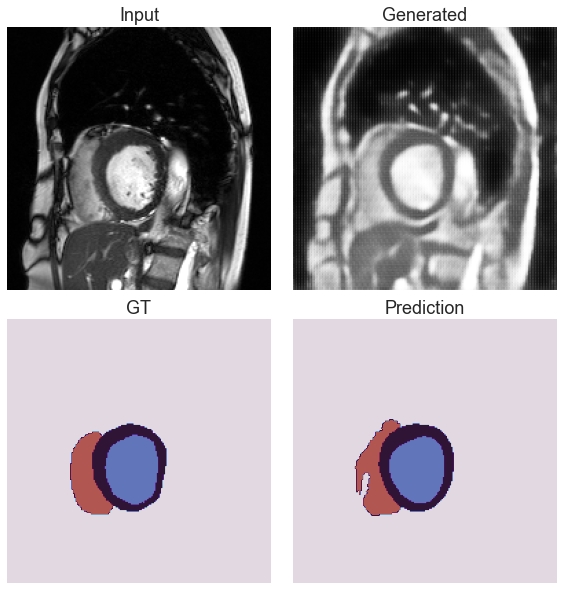

In [112]:
slice_id =7
sns.set(font_scale=1.5)
w_l,w_r = 0,after_predicted_maps.shape[2]
fig, axes = plt.subplots(2,2,squeeze=False,figsize=(8,8))
axes[0,0].imshow(imageV.data.cpu().numpy()[slice_id,0][w_l:w_r,w_l:w_r],cmap='gray')
axes[0,0].set_title('Input')
axes[0,1].imshow(corrupted_img.data.cpu().numpy()[slice_id,0][w_l:w_r,w_l:w_r],cmap='gray')
axes[0,1].set_title('Generated')
axes[1,0].imshow(label[slice_id][w_l:w_r,w_l:w_r],vmin=0,vmax=num_classes,cmap=label_cmap)
axes[1,0].set_title('GT')
axes[1,1].imshow(after_predicted_maps[slice_id][w_l:w_r,w_l:w_r],vmin=0,vmax=num_classes,cmap=label_cmap)
axes[1,1].set_title('Prediction')

for axj in axes:
    for ax in axj: 
        ax.axis('off')
    
plt.tight_layout(h_pad=0.5,w_pad=0,pad=0)
plt.show()

In [ ]:
# slice_id =4

entr_img = entropy(imageV.data.cpu().numpy()[slice_id,0], disk(5))
entr_sty_img = entropy(corrupted_img.data.cpu().numpy()[slice_id,0], disk(5))

import seaborn as sns
afunction = NGF(sigma=3)
loss = afunction(corrupted_img,imageV)
fig, axes = plt.subplots(3,3,squeeze=False,figsize=(10,9))
sns.set(font_scale=1.5)
axes[0,0].imshow(imageV.data.cpu().numpy()[slice_id,0],cmap = 'gray')
axes[0,0].set_title('Input')

axes[0,1].imshow(corrupted_img.data.cpu().numpy()[slice_id,0],cmap = 'gray')
axes[0,1].set_title('Generated')

axes[0,2].imshow(((corrupted_img-imageV)).cpu().data.numpy()[slice_id,0],cmap = 'RdBu',vmin=-1,vmax=1)
axes[0,2].set_title('Diff')

axes[1,0].imshow(np.sqrt(afunction.fixed_gradient.cpu().data.numpy()[slice_id,0]**2+afunction.fixed_gradient.cpu().data.numpy()[slice_id,1]**2),cmap = 'RdBu',vmin=-1,vmax=1)
axes[1,0].set_title('Grad')

axes[1,1].imshow(np.sqrt(afunction.moving_gradient.cpu().data.numpy()[slice_id,0]**2+afunction.moving_gradient.cpu().data.numpy()[slice_id,1]**2),cmap = 'RdBu',vmin=-1,vmax=1)
axes[1,1].set_title('Grad')

axes[1,2].imshow(afunction.ncc_map.cpu().data.numpy()[slice_id],cmap='jet')
axes[1,2].set_title('Corr')

axes[2,0].imshow(entr_img,cmap = 'viridis')
axes[2,0].set_title('Ent')

axes[2,1].imshow(entr_sty_img,cmap = 'viridis')
axes[2,1].set_title('Ent')

axes[2,2].imshow(np.sqrt((entr_sty_img-entr_img)**2),cmap = 'inferno')
axes[2,2].set_title('Std')


for axj in axes:
    for ax in axj: 
        ax.axis('off')
    
plt.tight_layout(h_pad=0.1,w_pad=0.1)
plt.show()


In [ ]:
def EntropyLoss(input_):
    # print("input_ shape", input_.shape)
    mask = input_.ge(0.000001)
    mask_out = torch.masked_select(input_, mask)
    entropy = -(torch.sum(mask_out * torch.log(mask_out + 1e-5)))
    return entropy / float(input_.size(0))
    

outputs_target = torch.transpose(init_p_2,1,3).reshape(-1,num_classes)
target_softmax_out = nn.Softmax(dim=1)(outputs_target)
target_entropy = EntropyLoss(target_softmax_out)

temperature = 3.0
outputs_target_temp = outputs_target / temperature
target_softmax_out_temp = nn.Softmax(dim=1)(outputs_target_temp)
target_entropy_weight = EntropyLoss(target_softmax_out_temp).detach()
target_entropy_weight = 1 + torch.exp(-target_entropy_weight)
target_entropy_weight =outputs_target.size(0)  * target_entropy_weight / torch.sum(target_entropy_weight)

cov_matrix_t_temp_map = target_softmax_out_temp.mul(target_entropy_weight.view(-1,1)).transpose(1,0).mm(target_softmax_out_temp)
cov_matrix_t_temp = cov_matrix_t_temp_map / torch.sum(cov_matrix_t_temp_map, dim=1)

mcc_loss = (torch.sum(cov_matrix_t_temp) - torch.trace(cov_matrix_t_temp)) / outputs_target.size(1)
print (mcc_loss)

In [ ]:
slice_id=1
plt.subplot(321)
plt.imshow(imageV.data.cpu().numpy()[slice_id,0][w_l:w_r,w_l:w_r],cmap='gray')
plt.axis('off')

plt.subplot(322)
plt.imshow(corrupted_img.data.cpu().numpy()[slice_id,0][w_l:w_r,w_l:w_r],cmap='gray')
plt.axis('off')
plt.subplot(323)
plt.imshow(entr_img[w_l:w_r,w_l:w_r], cmap='viridis')
plt.axis('off')
# plt.colorbar()

plt.subplot(324)
plt.imshow(entr_sty_img[w_l:w_r,w_l:w_r], cmap='viridis')
# plt.colorbar()
plt.axis('off')


plt.subplot(325)
plt.grid('off')
plt.axis('off')
plt.imshow(label[slice_id][w_l:w_r,w_l:w_r])
plt.subplot(326)
plt.imshow(after_predicted_maps[slice_id][w_l:w_r,w_l:w_r])
plt.grid('off')
plt.axis('off')
sns.axisgrid=False
plt.tight_layout(h_pad=0,w_pad = 0,pad=0)
plt.show()

In [ ]:
## style augmentation:
from styleaug import StyleAugmentor

def art_style_aug(im_tensor):
    n,c,h,w = im_tensor.size()
    if c==1:
        im_tensor_rgb = im_tensor.expand(n,3,h,w)
    elif c==3:
        im_tensor_rgb = im_tensor
    else:
        print (f'check input dim, either gray scale images (c=1) or rgb images (c=3), got c={c}')
        raise ValueError
    
    stylized_image = StyleAugmentor(im_tensor_rgb)
    ## convert back to gray
    if c==1:
        stylized_image = torch.mean(stylized_image,dim=1)
    return stylized_image

stylized_image = art_style_aug(imageV)

In [ ]:
decoder_layers_indexes = torch.tensor([2,3,4,5])
total_l = len(decoder_layers_indexes)
num_layers = torch.randint(low=1, high=total_l + 1,size=(1,)).short()
# select which layers to mix
print (num_layers)
random_index = torch.randperm(total_l)
print (random_index)
decoder_layers_indexes[random_index]
selected_layers = decoder_layers_indexes[:num_layers]
selected_layers= list(selected_layers.numpy())
selected_layers

In [ ]:
## Note: here, we use a fixed threhold each time for ease of comparison
# layers_settings =[[],[0],[0,1],[0,1,2],[0,1,2,3],[0,1,2,3,4],[0,1,2,3,4,5]]
#
from medseg.models.custom_loss import calc_correlation
lamdas =[0.,0.1,0.3,0.5,0.7,0.9,1.0]
lamdas =[l for l in lamdas]
layers_indexes=[2,3,4]
mix='gaussian'
extrapolate=False
results = {}

for j,lmda in enumerate(lamdas):
    corrupted_img = style_aug_inference(z_i.detach().clone(), decoder_function=segmentation_model.model['image_decoder'],
                                        layers_indexes=layers_indexes,lmda=lmda,mix=mix,if_extraplolate=extrapolate, fix_random_seed=2021)
    print (lmda)
    # compute code preservation:
    with torch.no_grad():
        zi_new,zs_new = segmentation_model.encode_image(corrupted_img.detach().clone())
        code_preserve_ratio = compute_batchwise_sim(zi_new,z_i)
        shape_code_preserve_ratio = compute_batchwise_sim(zs_new,z_s)
    init_p = segmentation_model.decode_segmentation(zs_new)
    predicted_maps = init_p.max(1)[1].cpu().numpy()
    results[str(lmda)] = [corrupted_img,code_preserve_ratio,shape_code_preserve_ratio,predicted_maps]

# visualization
vis_result_dict(ref_image=image,result_dict=results,figsize=(15,20))
plt.tight_layout()


In [ ]:
from medseg.models.custom_loss import calc_correlation,contour_loss
import random
mix_styles = [  
                # 'image/channel','image/channel_reverse',
                # 'seg/channel','seg/channel_reverse',
                #  'image/channel','seg/channel', 'seg+contour_preserving/channel','seg+content_preserving/channel',
                # 'image/spatial','seg/spatial', 'seg+contour_preserving/spatial','seg+content_preserving/spatial',
                # 'image_l1/channel',  'image_l2/channel',
                # 'image_l1/spatial',  'image_l2/spatial',

                'image_l1/channel', 'image_l1+contour_preserving/channel',
                'image_l1/spatial', 'image_l1+contour_preserving/spatial',
                
                # 'seg/channel', 'seg+contour_preserving/channel',
                # 'seg/spatial', 'seg+contour_preserving/spatial',
                # 'image_seg/channel', 'image_seg/channel_reverse',
                # 'image/spatial','seg/spatial',
                # 'image_seg/spatial','image_seg/spatial_reverse' 
                ]

layers_indexes=[0,1,2,3,4]
results = {}
extrapolate=True
lmda = 0.
percentile = 0.3
for j,style in enumerate(mix_styles):
    segmentation_model.eval()
    segmentation_model.zero_grad()
    if 'latent_noise' == style:
        perturbed_z_i_0 = z_i+torch.randn_like(z_i,device=z_i.device)*0.5
        corrupted_img =segmentation_model.decoder_inference(decoder =segmentation_model.model['image_decoder'],
                                                                    latent_code = perturbed_z_i_0,eval=eval,disable_track_bn_stats=True)
    
    elif 'image' in style or 'seg' in style:
        
        scope,mask_method = style.split('/')[0],style.split('/')[1]
        recon_image = segmentation_model.decode_image(z_i)
        p = segmentation_model.decode_segmentation_from_image_code(z_i,disable_track_bn_stats=True)
        if 'image_l1' == scope:
            im_rec_loss = nn.L1Loss()(recon_image,imageV.detach())
            contour_l =  contour_loss(recon_image,imageV.detach(),ignore_background=False, one_hot_target=False)

            print (f'{scope}: rec:{im_rec_loss.item()} contour, {contour_l.item()}')
            loss  = im_rec_loss

        elif 'image_l2' == scope:
            im_rec_loss = 0.5*nn.MSELoss()(recon_image,imageV.detach())
            print (f'{scope} im:{im_rec_loss.item()}')
            loss  = im_rec_loss
        

        elif 'image+contour_preserving' ==scope:
            im_rec_loss = 0.5*nn.MSELoss()(recon_image,imageV.detach())
            contour_l =  contour_loss(recon_image,imageV.detach(),ignore_background=False, one_hot_target=False)
            print (f'{scope}: rec:{im_rec_loss.item()} contour, {contour_l.item()}')

            loss = im_rec_loss-contour_l
        elif 'image_l1+contour_preserving' ==scope:
            im_rec_loss = nn.L1Loss()(recon_image,imageV.detach())
            contour_l = contour_loss(recon_image,imageV.detach(),ignore_background=False, one_hot_target=False)
            print (f'{scope}: rec:{im_rec_loss.item()} contour, {contour_l.item()}')

            loss = im_rec_loss-contour_l
        elif 'seg' == scope:
            loss  =cross_entropy_2D(p,labelV)
        elif 'seg+contour_preserving' ==scope:
            seg_loss = cross_entropy_2D(p,labelV)
            contour_l = contour_loss(recon_image,imageV.detach(),ignore_background=False, one_hot_target=False)
            print (f'{scope}: seg:{seg_loss.item()} contour, {contour_l.item()}')

            loss = seg_loss-contour_l
        elif 'seg+content_preserving' ==scope:
            seg_loss = cross_entropy_2D(p,labelV)
            mse_loss = nn.MSELoss()(recon_image,imageV.detach())
            print (f'im:{seg_loss.item()} mse, {mse_loss.item()}')
            loss = seg_loss-mse_loss
         ## increasing the seg loss while preserving the image content:
        gradient = torch.autograd.grad(loss, [z_i])[0]
        n,c,h,w = z_i.size(0),z_i.size(1),z_i.size(2),z_i.size(3)
        if mask_method== 'spatial' or mask_method== 'spatial_reverse':
            # mask gradient with largest response:
            spatial_mean = torch.mean(gradient, dim=1, keepdim=True)
            spatial_mean = spatial_mean.squeeze().view(n, h*w)
            vector_thresh_percent = int(h*w * percentile)
            vector_thresh_value = torch.sort(spatial_mean, dim=1, descending=True)[0][:, vector_thresh_percent]
            vector_thresh_value = vector_thresh_value.view(n, 1).expand(n, h*w)

            vector = torch.where(spatial_mean > vector_thresh_value,
                                0.5 * torch.rand_like(spatial_mean),
                                torch.ones_like(spatial_mean))
            mask_all = vector.view(n, 1, h, w)
            if 'reverse' in mask_method:
                vector =1-vector
   
        elif mask_method =='channel'or mask_method== 'channel_reverse':
            gradient_channel_mean = torch.mean(gradient.view(n, c, -1), dim=2)
       
            vector_thresh_percent = int(c * percentile)
            vector_thresh_value = torch.sort(gradient_channel_mean, dim=1, descending=True)[0][:, vector_thresh_percent]
            vector_thresh_value = vector_thresh_value.view(n, 1).expand(n, c)

            vector = torch.where(gradient_channel_mean > vector_thresh_value,
                             0.5 * torch.rand_like(gradient_channel_mean),
                             torch.ones_like(gradient_channel_mean))
            if 'reverse' in mask_method:
                vector =1-vector
   
            mask_all = vector.view(n, c, 1, 1)
            
        perturbed_z_i_0 = mask_all*z_i
        corrupted_img =segmentation_model.decoder_inference(decoder =segmentation_model.model['image_decoder'],
                                                                    latent_code = perturbed_z_i_0,eval=eval,disable_track_bn_stats=True)
    else:
        extrapolate=True if style =='gaussian' else False
        almda = 1.0 if style =='gaussian' else None
        corrupted_img = style_aug_inference(z_i.detach().clone(), decoder_function=segmentation_model.model['image_decoder'],
                                layers_indexes=layers_indexes,lmda=almda,mix=style,if_extraplolate=extrapolate,fix_random_seed=2021)
    
    print (corrupted_img.min())
    print (corrupted_img.max())

    corrupted_img = torch.clamp(corrupted_img,0,1)
    # corrupted_img  = corrupted_img*percentile+imageV*(1-percentile)
    if 'l1' in scope:    im_rec_loss = nn.L1Loss()(corrupted_img,imageV.detach())
    else:     im_rec_loss = nn.MSELoss()(corrupted_img,imageV.detach())

    contour_l =contour_loss(corrupted_img,imageV.detach(),ignore_background=False, one_hot_target=False)

    print (f'after {scope}: rec:{im_rec_loss.item()} contour, {contour_l.item()}')


    # compute code preservation:
    with torch.inference_mode():
        zi_new,zs_new = segmentation_model.encode_image(corrupted_img.detach().clone(),disable_track_bn_stats=True)
        code_preserve_ratio = compute_batchwise_sim(zi_new,z_i)
        shape_code_preserve_ratio = compute_batchwise_sim(zs_new,z_s)
    init_p = segmentation_model.decode_segmentation(zs_new,disable_track_bn_stats=True)
    predicted_maps = init_p.max(1)[1].cpu().numpy()
    results[str(style)] = [corrupted_img,code_preserve_ratio,shape_code_preserve_ratio,predicted_maps]

vis_result_dict(ref_image=image,result_dict=results,figsize=(15,25))


In [ ]:
from medseg.models.custom_loss import calc_correlation,contour_loss
import random
mix_styles = [  
               'seg w/ shape preserve'
                ]

results = {}
lr =1
num_steps = 1
segmentation_model.eval()
detached_z_i  =z_i.detach().clone()
for j,style in enumerate(mix_styles):
    ## adaptive instance normalization
    instance_std, instance_mean = torch.std_mean(detached_z_i,dim=(2,3),keepdim=True)
    std_std, std_mean =torch.std_mean(instance_std,dim=0,keepdim=True)
    mean_std, mean_mean =torch.std_mean(instance_mean,dim=0,keepdim=True)
    instance_std = instance_std.detach().clone()
    instance_mean = instance_mean.detach().clone()
    std_std.requires_grad=False
    std_mean.requires_grad=False
    mean_std.requires_grad=False
    mean_mean.requires_grad=False

    scale = torch.randn(z_i.size(0),1,z_i.size(2),z_i.size(3),requires_grad=False,device=z_i.device)*std_std.detach().clone()+std_mean.detach().clone()
    shift = torch.randn(z_i.size(0),1,z_i.size(2),z_i.size(3),requires_grad=False,device=z_i.device)*mean_std.detach().clone()+mean_mean.detach().clone()
    scale = scale.detach().clone()
    shift = shift.detach().clone()
    scale.requires_grad=True
    shift.requires_grad=True

    optimizer  = torch.optim.Adam(params=[scale,shift],lr = lr)
    for i in range(num_steps):
        new_scale =scale*std_std+std_mean
        new_shift =shift*mean_std+mean_mean
  
    ## target_scale*(x-mean(x))/x_std+target_mean
        new_z_i = (detached_z_i-instance_mean.detach().clone())/instance_std.detach().clone()*(new_scale)+(new_shift)

        recon_image = segmentation_model.decode_image(new_z_i)
        p = segmentation_model.decode_segmentation_from_image_code(new_z_i,disable_track_bn_stats=True)
      
        image_loss = calc_angular_loss(recon_image,imageV.detach().clone())
        

        seg_loss  = cross_entropy_2D(p,labelV.detach())
        print(f'{i}:, {image_loss.item()}, {seg_loss.item()}')

        optimizer.zero_grad()
        loss  = image_loss-seg_loss
        loss.backward()
        optimizer.step()


    
    # [scale_g, shift_g] = torch.autograd.grad(seg_loss, [scale,shift])
    # [scale_g, shift_g] = torch.autograd.grad(seg_loss-image_loss, [scale,shift])
    # scale_g_instance_max= torch.norm(scale_g,dim=1,keepdim=True)
    # shift_g_instance_max= torch.norm(shift_g,dim=1,keepdim=True)
    # scale_g/= scale_g_instance_max
    # shift_g/=shift_g_instance_max
    # scale =  scale+ lr*scale_g
    # shift =  shift+ lr*shift_g
    new_scale =scale*std_std+std_mean
    new_shift =shift*mean_std+mean_mean
  
    new_z_i = (detached_z_i-instance_mean)/instance_std*(new_scale)+(new_shift)

    new_z_i = new_z_i.detach().clone()
    corrupted_img =segmentation_model.decoder_inference(decoder =segmentation_model.model['image_decoder'],
                                                                    latent_code = new_z_i,eval=True,disable_track_bn_stats=True)
 
#     seg_code_mask = 
#     contour_code_mask = 

    # compute code preservation:
    with torch.inference_mode():
        zi_new,zs_new = segmentation_model.encode_image(corrupted_img.detach().clone(),disable_track_bn_stats=True)
        code_preserve_ratio = compute_batchwise_sim(zi_new,z_i)
        shape_code_preserve_ratio = compute_batchwise_sim(zs_new,z_s)
    init_p = segmentation_model.decode_segmentation(zs_new,disable_track_bn_stats=True)
    predicted_maps = init_p.max(1)[1].cpu().numpy()
    results[str(style)] = [corrupted_img,code_preserve_ratio,shape_code_preserve_ratio,predicted_maps]

vis_result_dict(ref_image=image,result_dict=results,figsize=(15,25))


In [ ]:
## add image cross correlation module

def compute_cosine_similarity(input_a, input_b, reduce=None):
    b,c,h,w= input_a.size()
    assert b == input_b.size(0) and c == input_b.size(1) and h == input_b.size(2) and w == input_b.size(3), f'input size mismatch, got {input_a.size()} {input_b.size()}'
    flattent_a = input_a.view(b,1)
    flattent_b = input_b.view(b,-1)
    sim = torch.nn.CosineSimilarity(dim=1)(flatten_a,flatten_b)
    if reduce is None:
        sim = sim.view(b,c,h,w)
    elif reduce =='batch':
        sim = torch.mean(sim,dim=1)
    elif reduce == 'mean':
        sim = torch.mean(sim)
    else: raise ValueError
    return sim


image_sim_map = compute_cosine_similarity(recon_image,imageV.detach().clone())


In [ ]:
import seaborn as sns
from skimage.transform import rescale, resize, downscale_local_mean
seg_gradient_npy = scale_g.data.cpu().numpy()
# seg_gradient_npy /= np.max(seg_gradient_npy)
contour_gradient_npy = shift_g.data.cpu().numpy()
# contour_gradient_npy /= np.max(contour_gradient_npy)

print (contour_gradient_npy.shape)

slice_id = 4
print (seg_gradient_npy.sum())
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(np.sum(imageV.data.cpu().numpy(),axis=1)[slice_id])
plt.subplot(132)
plt.imshow(resize(seg_gradient_npy[slice_id,0],(192,192)),cmap='jet')
# plt.colorbar()
plt.subplot(133)
plt.imshow(resize(contour_gradient_npy[slice_id,0],(192,192)),cmap='jet')
# plt.colorbar()


In [ ]:
## perform style interpolation in the encoder part
from medseg.models.model_util import _disable_tracking_bn_stats
import torch.nn.functional as F

def style_aug_encoder(x, encoder_function, layers_indexes=[],lmda=None,mix='random',if_extrapolate=False):
    if len(layers_indexes)==0:
        with _disable_tracking_bn_stats(encoder_function):
            z= encoder_function(x)
        return z
    if len(layers_indexes)>0:
        print(layers_indexes)
        mixstyle = MixStyle(p=1, alpha=0.1,lmda=lmda,mix=mix,extraplolate=if_extrapolate)
        with _disable_tracking_bn_stats(encoder_function):
            if 0 in layers_indexes:
                x = mixstyle(x)
            x1 = encoder_function.inc(x)
            if 1 in layers_indexes:
                x1 = mixstyle(x1)
            x2 = F.leaky_relu(x1, negative_slope=0.2)

            x3 = encoder_function.down1.get_features(x2)
            if 2 in layers_indexes:
                x3 = mixstyle(x3)
            x3 = encoder_function.down1.non_linear(x3)

            x4 = encoder_function.down2.get_features(x3)
            if 3 in layers_indexes:
                x4 = mixstyle(x4)
            x4 = encoder_function.down2.non_linear(x4)
   
            x5 = encoder_function.down3.get_features(x4)
            if 4 in layers_indexes:
                x5 = mixstyle(x5)
            x5 = encoder_function.down3.non_linear(x5)
            x5 = encoder_function.down4.get_features(x5)
            if 5 in layers_indexes:
                x5 = mixstyle(x5)
            x5 = encoder_function.down4.non_linear(x5)
            x5 = encoder_function.final_conv(x5)
            if encoder_function.act is not None:
                x5 = encoder_function.act(x5)

            # if 0 in layers_indexes:
            #     x = mixstyle(x)
            # x1 = encoder_function.inc(x)
            # x2 = F.leaky_relu(x1, negative_slope=0.2)
            # if 1 in layers_indexes:
            #     x2 = mixstyle(x2)
            # x3 = encoder_function.down1(x2)
            # if 2 in layers_indexes:
            #     x3 = mixstyle(x3)

            # x4 = encoder_function.down2(x3)
            # if 3 in layers_indexes:
            #     x4 = mixstyle(x4)
   
            # x5 = encoder_function.down3(x4)
            # if 4 in layers_indexes:
            #     x5 = mixstyle(x5)
            # x5 = encoder_function.down4(x5)
            # if 5 in layers_indexes:
            #     x5 = mixstyle(x5)
            # x5 = encoder_function.final_conv(x5)
            # x5 = encoder_function.act(x5)
        return x5

In [ ]:

def mixup_encoder(x,  encoder_function,label_map=None,num_classes=None,layers_indexes=[],lmda=None,perm_index=None,use_gpu=True):
    ## apply mixup in the decoder path 
    if len(layers_indexes)==0:
        with _disable_tracking_bn_stats(encoder_function):
            y= encoder_function(x)
        return y,label_map,torch.arange(x.size(0)).to(x.device)
    elif len(layers_indexes)==1:
        ## only support one layer to mixup
        print(layers_indexes)
        mixup_util = ManifoldMixup(alpha=2.0,use_gpu=use_gpu)
        if lmda is not None:
            ## if lam has been provided, then use the provided one
            mixup_util.lam =lmda
        if perm_index is not None:
            mixup_util.perm_index = perm_index
        with _disable_tracking_bn_stats(encoder_function):
            if 0 in layers_indexes:
                x,label_map = mixup_util.get_mixup_data(x,label_map,num_classes=num_classes)
            x1 = encoder_function.inc(x)
            x2 = F.leaky_relu(x1, negative_slope=0.2)
            if 1 in layers_indexes:
                x2 ,label_map= mixup_util.get_mixup_data(x2,label_map,num_classes=num_classes)
            x3 = encoder_function.down1(x2)
            if 2 in layers_indexes:
                x3,label_map = mixup_util.get_mixup_data(x3,label_map,num_classes=num_classes)

            x4 = encoder_function.down2(x3)
            if 3 in layers_indexes:
                x4,label_map =  mixup_util.get_mixup_data(x4,label_map,num_classes=num_classes)

   
            x5 = encoder_function.down3(x4)
            if 4 in layers_indexes:
                x5 ,label_map=  mixup_util.get_mixup_data(x5,label_map,num_classes=num_classes)
            x5 = encoder_function.down4(x5)
            if 5 in layers_indexes:
                x5,label_map =  mixup_util.get_mixup_data(x5,label_map,num_classes=num_classes)
            x5 = encoder_function.final_conv(x5)
            if encoder_function.act is not None:
                x5 = encoder_function.act(x5)
        return x5,label_map,mixup_util.perm_index
    else:
        raise ValueError("only features of one layer can be mixed")

In [ ]:
aug_z = style_aug_encoder(x=imageV,encoder_function=segmentation_model.model['image_encoder'].general_encoder,layers_indexes=[],lmda=1,mix='random')

In [ ]:
## Note: here, we use the target style statistics each time for ease of comparison
layers_settings =[[],[1,2,3]]
lmda=1.0
mix='gaussian'
extrapolate=True

results = {}
segmentation_model.train()
for j,layer_index_list in enumerate(layers_settings):
    aug_z = style_aug_encoder(imageV.detach().clone(), segmentation_model.model['image_encoder'].general_encoder,
                                layers_indexes=layer_index_list,lmda=lmda,mix=mix,if_extrapolate=extrapolate)
    # perm_index = 0*torch.arange(z_i.size(0)-1,-1,-1).to(z_i.device)
    
    # aug_z,label_map,perm_index = mixup_encoder(x=imageV.detach().clone(), 
    #                     encoder_function=segmentation_model.model['image_encoder'].general_encoder,
    #                     label_map=None,num_classes=None,layers_indexes=layer_index_list,lmda=lmda,perm_index=perm_index,use_gpu=True)
    decoder = segmentation_model.model["image_decoder"]
    with _disable_tracking_bn_stats(decoder):
        corrupted_img =  decoder(aug_z)
    corrupted_img = rescale_intensity(corrupted_img,0,1)
    # compute code preservation:
    with torch.no_grad():
        zi_new,zs_new = segmentation_model.encode_image(corrupted_img.detach().clone())
        code_preserve_ratio = compute_batchwise_sim(zi_new,z_i)
        shape_code_preserve_ratio = compute_batchwise_sim(zs_new,z_s)
        init_p = segmentation_model.decode_segmentation(zs_new,disable_track_bn_stats=True)
        predicted_maps = init_p.max(1)[1].cpu().numpy()
    results[str(layer_index_list)] = [corrupted_img,code_preserve_ratio,shape_code_preserve_ratio,predicted_maps]

vis_result_dict(ref_image=image,result_dict=results,figsize=(15,10))

In [ ]:
imageV.size()

In [ ]:
from medseg.models.custom_loss import cross_entropy_2D,SoftDiceLoss

mix_styles = ['None','random','worst','gaussian','batch_center']
layers_indexes=[1,2,3]
lmda=0.5
extrapolate=[False,False,False,True,True]
results = {}
segmentation_model.train()
for j,style in enumerate(mix_styles):
    if style=='None':
        aug_z = segmentation_model.model['image_encoder'].general_encoder(imageV)
    else:
        aug_z = style_aug_encoder(imageV.detach().clone(), segmentation_model.model['image_encoder'].general_encoder,layers_indexes=layers_indexes,lmda=lmda,mix=style,
                    if_extrapolate=extrapolate[j])
    print (aug_z.size())
    decoder = segmentation_model.model["image_decoder"]
    init_p = segmentation_model.decode_segmentation_from_image_code(aug_z)
    predicted_maps = init_p.max(1)[1].cpu().numpy()
    with _disable_tracking_bn_stats(decoder):
        corrupted_img =  decoder(aug_z)    # compute code preservation:
    corrupted_img = rescale_intensity(corrupted_img,0,1)
    with torch.no_grad():
        zi_new,zs_new = segmentation_model.encode_image(corrupted_img.detach().clone(),disable_track_bn_stats=True)
        code_preserve_ratio = compute_batchwise_sim(zi_new,z_i)
        shape_code_preserve_ratio = compute_batchwise_sim(zs_new,z_s)
        init_p = segmentation_model.decode_segmentation(zs_new,disable_track_bn_stats=True)
        predicted_maps = init_p.max(1)[1].cpu().numpy()
        shape_code_preserve_ratio = compute_batchwise_dice(predicted_maps,label,n_classes= num_classes)
    results[str(style)] = [corrupted_img,code_preserve_ratio,shape_code_preserve_ratio,predicted_maps]
vis_result_dict(ref_image=image,ref_gt = label, result_dict=results,figsize=(20,40))
plt.tight_layout()